# Marks DM Profile Creator

Based on Chris Kiehl's original work.

In [4]:
from matplotlib.pyplot import *
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, PathPatch
import scipy.integrate as integrate
import numpy as np
from scipy.optimize import curve_fit
import cmath
import csv
from numpy import array as arr
from copy import copy
from scipy.special import factorial 
%matplotlib inline
import sys
sys.path.append("..")
import Miscellaneous as misc

In [5]:
def getKnoll(n,m):
    return (n*(n+2)+m)/2
def fromNoll(j):
    n = 0
    m = 0
    while (j > n):
        n += 1
        j -= n
    m = -n+2*j
    return n,m
# make sure these are inverses.
for j in range(200):
    if j != getKnoll(*fromNoll(j)):
        print('!')

In [6]:
from numpy import array as arr

In [7]:
def toPolar(x,y):
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    return r,phi
def toCartesian(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y
# make sure these are inverses
for x in np.linspace(-1,1,100):
    for y in np.linspace(-1,1,100):
        if (arr((x,y)) -arr(toCartesian(*toPolar(x,y)))>1e-9).any():
            print('!')

In [8]:
def zernikeTheta(m,theta):
    if (m >= 0):
        return np.cos(m*theta)
    else:
        return np.sin(-m*theta)
def zernikeRadial(n,m,r):
    m = abs(m)
    if (m > n):
        print('Error: n must be greater than or equal to n!')
        return 0
    if (((n-m)%2) > 0):
        print('Error: (n - m) must be even!')
        return 0
    kArray = np.linspace(0,(n-m)/2,int((n-m)/2+1))
    rArray = 0
    i = 0
    for k in kArray:
        rArray=rArray+(r**(n-2*k))*((-1)**k)*factorial(n-k)/(factorial(k)*factorial((n+m)/2-k)*factorial((n-m)/2-k))
        i = i+1
    return rArray
def normalization(n,m):
    """ Unused? I think the normalization is built in"""
    if (m == 0) :
        a = 2*np.pi
    else:
        a = 1*np.pi
    return np.sqrt((2*n+2)/a)
# put the above together.
def zernike(n,m,x,y):
    return zernikePolar(n,m,*toPolar(x,y))
    #r,theta = polar(x,y)
    #return zernikeTheta(m,theta)*zernikeRadial(n,m,r)*normalization(n,m)
def zernikePolar(n,m,r,theta):
    return zernikeTheta(m,theta)*zernikeRadial(n,m,r)*normalization(n,m)

In [9]:
def zernikeFit(X,*param):
    x,y = X
    height = param[0]*zernike(fromNoll(0)[0],fromNoll(0)[1],x,y)
    for k in range(1,41):
        height += param[k]*zernike(fromNoll(k)[0],fromNoll(k)[1],x,y)
    return height

## Verifying Orthogonality

In [10]:
n = 5
m = 1
#def integrand(r,theta):
 #   return r*zernikePolar(n,m,r,theta)**2
f = lambda theta, r: r*zernikePolar(4,0,r,theta)*zernikePolar(4,2,r,theta)
# should be small, presumably.
print(integrate.dblquad(f, 0, 1, lambda r: 0, lambda r: 2*np.pi))

(-7.243814608430614e-17, 9.871058785287423e-09)


## DM Lookup Table

In [11]:
def myDmLookup(pixNum, factor=1/3.0):
    if not (0 <= pixNum <= 136):
        raise ValueError('Invalid Pixel Number!')
    rowOff = [4,2,1,1,0,0,0,0,0,1,1,2,4]
    numInRow = []
    yInit = 6
    for rowOffset in rowOff:
        numInRow.append((7-(rowOffset+1))*2+1)
    #sum(numInRow) = 137
    centerOffset = -((arr(numInRow)-1)/2).astype(int)
    pn = copy(pixNum)
    for rowNum, num in enumerate(numInRow):
        pn -= num
        if pn < 0:
            pn += num
            return [factor*(centerOffset[rowNum]+pn), factor*(yInit-rowNum)]
    raise ValueError('ERROR: Somehow made it to the end of the loop depsite passing the initial value range check...')

## Program Pure Zernike Polynomials

In [12]:
import os

In [13]:
def readZernikeFile(file):
    valArray = []
    with open(file) as f:
        lines = f.readlines()
        for l in lines:
            valArray.append(float(l))
    return valArray

In [14]:
def writeZernikeFile(valArray, outFile):
    # not sure if any need to do this slightly more convoluted writing, but just copying chris's method.
    with open(outFile, 'w', newline='') as csvfile:
        DM_Writer = csv.writer(csvfile, delimiter=' ', quotechar ='|', quoting=csv.QUOTE_MINIMAL)
        for v in valArray:
            DM_Writer.writerow([v])

In [15]:
def makeIm(actuatorValueList):
    avl = actuatorValueList
    pic = np.zeros((13,13))+0.5
    rowOff = [4,2,1,1,0,0,0,0,0,1,1,2,4]
    tc = 0
    for i, rowO in enumerate(rowOff):
        numInRow = (7-(rowO+1))*2+1
        for j in range(numInRow):
            pic[i][rowO+j] = avl[tc]
            tc += 1
    return pic

In [16]:
def checkValues(vals):
    for i, volt in enumerate(vals):
        if not (0 < volt < 1):
            print('Voltage out of range! Actuator: ', i,', Value:', volt)

In [17]:
def addComa(zAmps, comaMag, comaAngle):
    """
    Adds at a particular angle and magnitude to a list of zernike amplituders.
    """
    x,y = toCartesian(comaMag,comaAngle)
    zAmps[7] += x
    zAmps[8] += y
    return zAmps

In [18]:
getKnoll(2,-2)

3.0

In [19]:
def addAstigmatism(zAmps, astigMag, astigAngle):
    """
    Adds at a particular angle and magnitude to a list of zernike amplituders.
    Astigmatism is 2,2 and 2,-2, so symmetric under pi rotation
    """
    x,y = toCartesian(astigMag,astigAngle)
    zAmps[3] += x
    zAmps[5] += y
    return zAmps

In [20]:
def addTrefoil(zAmps, trefMag, trefAngle):
    """
    Adds at a particular angle and magnitude to a list of zernike amplituders.
    Astigmatism is 2,2 and 2,-2, so symmetric under pi rotation
    """
    x,y = toCartesian(trefMag,trefAngle)
    zAmps[6] += x
    zAmps[9] += y
    return zAmps

In [21]:
def addSpherical(zAmps, sphereMag):
    """ just for consistency """
    zAmps[12] += sphereMag
    return zAmps

In [22]:
def createZernikeArray(amplitudes, baselineFile, quiet=False):
    vals = []
    inc = 1/3
    flatVoltage = np.linspace(0, 136, 137)
    newVoltage = np.linspace(0, 136, 137)
    sign=0
    with open(baselineFile, newline='') as csvfile:
        DM_Reader = csv.reader(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
        for i, row in enumerate(DM_Reader):
            flatVoltage[i]=row[0]
    for i in range(0,137):
        zernSum=0
        weightFactor = 1
        x,y = myDmLookup(i)
        if (x**2+y**2)<=1:
            for j, amp in enumerate(amplitudes):
                m,n = fromNoll(j)
                zernSum += amp*zernike(m,n,x,y)
        elif (x**2+y**2)<1.5:
            for j, amp in enumerate(amplitudes):
                m,n = fromNoll(j)
                r,t = toPolar(x,y)
                # use circle's edge (i.e. r=1) value at the angle of the pixel
                x_, y_ = toCartesian(1,t)
                zernSum += amp*zernike(m,n,x_,y_)
        volt = (-1 if zernSum <= 0 else 1)*zernSum**2*weightFactor+flatVoltage[i]
        vals.append(volt)
    if not quiet:
        checkValues(vals)
    return vals

In [23]:
vals_old = readZernikeFile('coma_test---.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'coma_test---.txt'

### piston (seeing used area)

In [21]:
currentAmps = np.linspace(0,0,45) 
mag = 0.2
vals_base = createZernikeArray(np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
currentAmps[0] = 0.2
vals_pist = writeZernikeFile(createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), outFile)

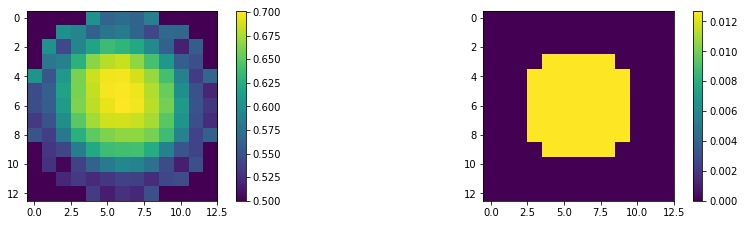

In [22]:
f, ax = subplots(1,2,figsize=(15,3.5))
im = ax[0].imshow(makeIm(vals_pist))
colorbar(im, ax=ax[0])
diffNew = makeIm(vals_pist)-makeIm(vals_base)
im = ax[1].imshow(diffNew)
colorbar(im, ax=ax[1])
#colorbar()

### coma

In [23]:
currentAmps = np.linspace(0,0,45) 
mag = 0.2
vals_base = createZernikeArray(np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
vals_new = createZernikeArray(addComa(currentAmps,0.2,np.pi/6), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
currentAmps = np.linspace(0,0,45) 
currentAmps[7] = 0.2
vals_vert = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt')

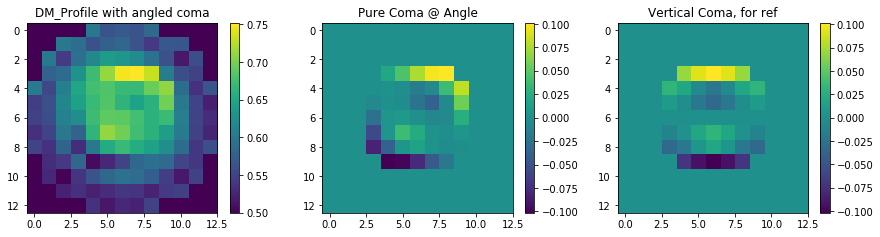

In [24]:
f, ax = subplots(1,3,figsize=(15,3.5))
im = ax[0].imshow(makeIm(vals_new))
colorbar(im, ax=ax[0])
diffNew = makeIm(vals_new)-makeIm(vals_base)
ax[0].set_title('DM_Profile with angled coma')
im = ax[1].imshow(diffNew)
colorbar(im, ax=ax[1])
ax[1].set_title('Pure Coma @ Angle')
diffvert = makeIm(vals_vert)-makeIm(vals_base)
im = ax[2].imshow(diffvert)
ax[2].set_title('Vertical Coma, for ref')
#im = ax[2].imshow(diffHor,vmax=max(diffNew.flatten()),vmin=min(diffNew.flatten()))
colorbar(im, ax=ax[2])

#colorbar()

### astigmastism

In [85]:
currentAmps = np.linspace(0,0,45) 
mag = 0.2
vals_base = createZernikeArray( np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt' )
vals_new = createZernikeArray( addComa(addAstigmatism(currentAmps,0.2,1*np.pi/2),0.1,3*np.pi/2), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')

Text(0.5,1,'Pure Coma @ Angle')

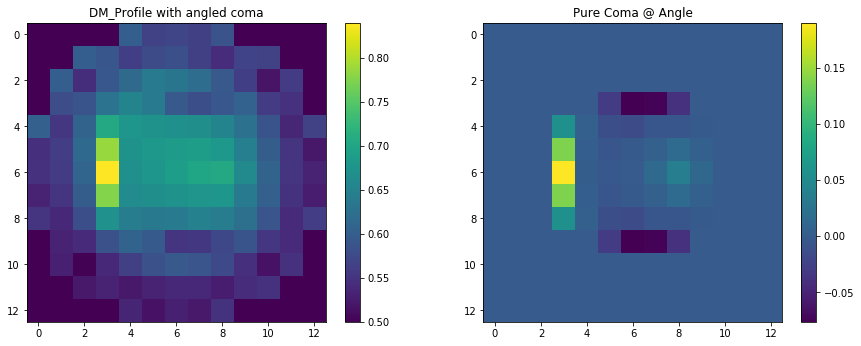

In [86]:
f, ax = subplots(1,2,figsize=(15,5.5))
im = ax[0].imshow(makeIm(vals_new))
colorbar(im, ax=ax[0])
diffNew = makeIm(vals_new)-makeIm(vals_base)
ax[0].set_title('DM_Profile with angled coma')
im = ax[1].imshow(diffNew)
colorbar(im, ax=ax[1])
ax[1].set_title('Pure Coma @ Angle')

#colorbar()

### spherical

In [95]:
getKnoll(4,0)

12.0

In [96]:
currentAmps = np.linspace(0,0,45) 
mag = 0.2
vals_base = createZernikeArray(np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
currentAmps[12] = 0.2
vals_new = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt')

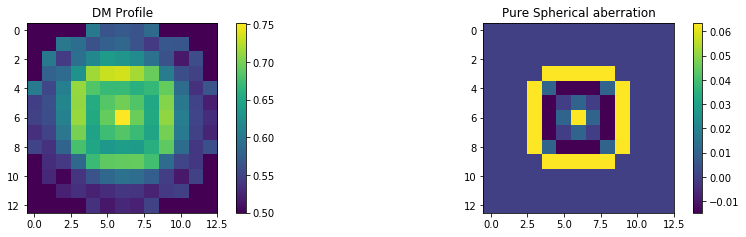

In [97]:
f, ax = subplots(1,2,figsize=(15,3.5))
im = ax[0].imshow(makeIm(vals_new))
colorbar(im, ax=ax[0])
ax[0].set_title('DM Profile')
diffNew = makeIm(vals_new)-makeIm(vals_base)
im = ax[1].imshow(diffNew)
ax[1].set_title('Pure Spherical aberration')
colorbar(im, ax=ax[1])
#colorbar()

### Trefoil

In [185]:
currentAmps = np.linspace(0,0,45) 
mag = 0.1
vals_base = createZernikeArray(np.zeros(45), '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
currentAmps = addTrefoil(currentAmps,mag,1*np.pi)
vals_new = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt')

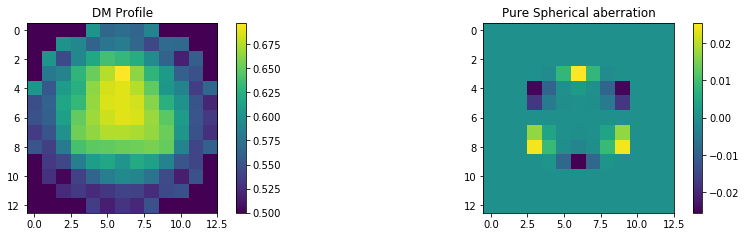

In [186]:
f, ax = subplots(1,2,figsize=(15,3.5))
im = ax[0].imshow(makeIm(vals_new))
colorbar(im, ax=ax[0])
ax[0].set_title('DM Profile')
diffNew = makeIm(vals_new)-makeIm(vals_base)
im = ax[1].imshow(diffNew)
ax[1].set_title('Pure Spherical aberration')
colorbar(im, ax=ax[1])
#colorbar()

# Scan 1

## Scan 1: Coma rotation:

In [29]:
import sys
sys.path.insert(0, "..")

In [30]:
import Miscellaneous as misc

In [31]:
for theta in np.arange(0,2*np.pi,0.1):
    currentAmps = np.zeros(45)
    writeZernikeFile(createZernikeArray(addComa(currentAmps,0.2,theta), '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan1_'+misc.round_sig_str(theta)+'.txt')

## Scan 2: Coma Magnitude

At theta = 3pi/2

In [39]:
for mag in np.arange(0,0.4,0.05):
    print('.',end='')
    currentAmps = np.zeros(45)
    writeZernikeFile(createZernikeArray(addComa(currentAmps,mag,3*np.pi/2), '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan2_'+misc.round_sig_str(mag)+'.txt')

........

## Scan3: Astigmatism Rotation

with 0.1 coma at 3pi/2 

In [87]:
for theta in np.arange(0,2*np.pi,0.1):
    print('.',end='')
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.1,3*np.pi/2)
    astigAmps = addAstigmatism(currentAmps,0.2,theta)
    writeZernikeFile(createZernikeArray(astigAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan3_'+misc.round_sig_str(theta)+'.txt')

...............................................................

## scan 4: Astigmatism Magnitude

In [93]:
for mag in np.arange(0,0.325,0.025):
    print('.',end='')
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.1,3*np.pi/2)
    astigAmps = addAstigmatism(currentAmps, mag, np.pi/2)
    writeZernikeFile(createZernikeArray(astigAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan4_'+misc.round_sig_str(mag)+'.txt')

.............

## scan 5 - X Position Scan

The X position scan

## scan 6: Coma Angle

being a bit aggresive with the amplitude, bumping it to 0.15 when had been set to 0.1 before astigmatism scan

In [94]:
for theta in np.arange(0,2*np.pi,0.1):
    print('.',end='')
    currentAmps = np.zeros(45)
    currentAmps = addAstigmatism(currentAmps, 0.15, np.pi/2)
    comaAmps = addComa(currentAmps,0.15,theta)
    writeZernikeFile(createZernikeArray(comaAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan6_'+misc.round_sig_str(theta)+'.txt')

...............................................................

## scan 7 - Spherical Magnitude

In [117]:
for mag in np.arange(-0.4,0.15,0.05):
    print('.',end='')
    currentAmps = np.zeros(45)
    currentAmps = addAstigmatism(currentAmps, 0.15, np.pi/2)
    currentAmps = addComa(currentAmps,0.1,3*np.pi/2)
    sphericalAmps = addSpherical(currentAmps,mag)
    writeZernikeFile(createZernikeArray(sphericalAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan7_'+misc.round_sig_str(mag)+'.txt')

...........

## scan 8 - Coma Magnitude

In [122]:
for mag in np.arange(0,0.4,0.025):
    print('.',end='')
    currentAmps = np.zeros(45)
    currentAmps = addAstigmatism(currentAmps, 0.15, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.15)
    comaAmps = addComa(currentAmps,mag,3*np.pi/2)
    writeZernikeFile(createZernikeArray(comaAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan8_'+misc.round_sig_str(mag)+'.txt')

................Voltage out of range! Actuator:  65 , Value: 1.0297599405926037


## scan9 - Astigmatism Magnitude

In [130]:
for mag in np.arange(0,0.325,0.025):
    print('.',end='')
    currentAmps = np.zeros(45)
    currentAmps = addSpherical(currentAmps,-0.15)
    currentAmps = addComa(currentAmps,0.225,3*np.pi/2)
    astigAmps = addAstigmatism(currentAmps, mag, np.pi/2)
    writeZernikeFile(createZernikeArray(astigAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan9_'+misc.round_sig_str(mag)+'.txt')

.............

## scan10 - defocus, done with telescope

## scan11 - Spherical again

after defocus changed, should check sphreical, also after changing coma

In [137]:
for mag in np.arange(-0.4,0.05,0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.225,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,mag)
    writeZernikeFile(createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan11_'+misc.round_sig_str(mag)+'.txt')

-0.4
-0.375
-0.35
-0.32499999999999996
-0.29999999999999993
-0.2749999999999999
-0.2499999999999999
-0.22499999999999987
-0.19999999999999984
-0.17499999999999982
-0.1499999999999998
-0.12499999999999978
-0.09999999999999976
-0.07499999999999973
-0.04999999999999971
-0.02499999999999969
3.3306690738754696e-16
0.025000000000000355


## scan12 - Coma Mag Again

In [141]:
for mag in np.arange(0,0.325,0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,mag,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.05)
    writeZernikeFile(createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan12_'+misc.round_sigcb_str(mag)+'.txt')

0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004


## Scan13 - Astig Mag Again

In [152]:
for mag in np.arange(0,0.2,0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.275,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, mag, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.05)
    writeZernikeFile(createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt'), 'Scan13_'+misc.round_sig_str(mag)+'.txt')

0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
Voltage out of range! Actuator:  65 , Value: 1.031153374921388


## Scan14 - X pos

## scan15 - Piston

In [163]:
for mag in np.arange(-0.45,-0,0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.275,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.05)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt')
    volts += mag
    checkValues(volts)
    writeZernikeFile(volts, 'Scan15_'+misc.round_sig_str(mag)+'.txt')

-0.45
-0.425
-0.39999999999999997
-0.37499999999999994
-0.3499999999999999
-0.3249999999999999
-0.2999999999999999
-0.27499999999999986
-0.24999999999999983
-0.2249999999999998
-0.1999999999999998
-0.17499999999999977
-0.14999999999999974
-0.12499999999999972
-0.0999999999999997
-0.07499999999999968
-0.049999999999999656
-0.024999999999999634


## Scan16 - Trefoil

In [193]:
for angle in np.arange(0, 2*np.pi, 0.1):
    print(angle)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.275,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.05)
    currentAmps = addTrefoil(currentAmps,0.1,angle)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = -0.2
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan16_'+misc.round_sig_str(angle)+'.txt')

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2


## Scan17 - Trefoil Mag

In [200]:
for mag in np.arange(0, 0.15, 0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.275,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.05)
    currentAmps = addTrefoil(currentAmps,mag,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = -0.2
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan17_'+misc.round_sig_str(mag)+'.txt')

0.0
0.025
0.05
0.07500000000000001
0.1
0.125


## Scan18 - Coma Mag

In [202]:
for mag in np.arange(0, 0.375, 0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,mag,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.05)
    currentAmps = addTrefoil(currentAmps,0.025,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = -0.2
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan18_'+misc.round_sig_str(mag)+'.txt')

0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.325
0.35000000000000003


## scan19 coma angle

In [25]:
for theta in np.arange(3*np.pi/2-1, 3*np.pi/2+1, 0.1):
    print(theta)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.3,theta)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.05)
    currentAmps = addTrefoil(currentAmps,0.025,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = -0.2
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan19_'+misc.round_sig_str(theta)+'.txt')

3.7123889803846897
3.8123889803846898
3.91238898038469
4.01238898038469
4.11238898038469
4.21238898038469
4.31238898038469
4.412388980384691
4.51238898038469
4.61238898038469
4.712388980384691
4.812388980384691
4.912388980384691
5.01238898038469
5.112388980384691
5.2123889803846915
5.312388980384691
5.412388980384691
5.512388980384691
5.612388980384692


## Scan20 Spherical

In [37]:
for mag in np.arange(-0.2,0.025, 0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.325,3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.125, np.pi/2)
    currentAmps = addSpherical(currentAmps,mag)
    currentAmps = addTrefoil(currentAmps,0.025,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = -0.2
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan20_'+misc.round_sig_str(mag)+'.txt')

-0.2
-0.17500000000000002
-0.15000000000000002
-0.12500000000000003
-0.10000000000000003
-0.07500000000000004
-0.050000000000000044
-0.02500000000000005
-5.551115123125783e-17


# Scan 2

## Scan 2.1 - Coma Mag

In [40]:
for mag in np.arange(0,0.38, 0.02):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,mag, 3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0, np.pi/2)
    currentAmps = addSpherical(currentAmps,0)
    currentAmps = addTrefoil(currentAmps,0,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = 0
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan2p1_'+misc.round_sig_str(mag)+'.txt')

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36


## Scan 2.2 - Astig Mag

In [44]:
for mag in np.arange(0,0.325, 0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.1, 3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, mag, np.pi/2)
    currentAmps = addSpherical(currentAmps,0)
    currentAmps = addTrefoil(currentAmps,0,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = 0
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan2p2_'+misc.round_sig_str(mag)+'.txt')

0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004


## Scan 2.3 - Spherical

In [48]:
for mag in np.arange(-0.3,0, 0.025):
    print(mag)
    currentAmps = np.zeros(45)
    currentAmps = addComa(currentAmps,0.1, 3*np.pi/2)
    currentAmps = addAstigmatism(currentAmps, 0.05, np.pi/2)
    currentAmps = addSpherical(currentAmps,mag)
    currentAmps = addTrefoil(currentAmps,0,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = 0
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan2p3_'+misc.round_sig_str(mag)+'.txt')

-0.3
-0.27499999999999997
-0.24999999999999994
-0.22499999999999992
-0.1999999999999999
-0.17499999999999988
-0.14999999999999986
-0.12499999999999983
-0.09999999999999981
-0.07499999999999979
-0.04999999999999977
-0.024999999999999745


## Scan 2.4 - Coma Angle

In [50]:
for theta in np.arange(0,2*np.pi, 0.05):
    print(theta)
    currentAmps = np.zeros(45)
    # 3pi/2
    currentAmps = addComa(currentAmps,0.1, theta)
    currentAmps = addAstigmatism(currentAmps, 0.05, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.2)
    currentAmps = addTrefoil(currentAmps,0,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = 0
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan2p4_'+misc.round_sig_str(theta)+'.txt')

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.25
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5
1.55
1.6
1.6500000000000001
1.7000000000000002
1.75
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.0500000000000003
2.1
2.15
2.2
2.25
2.3000000000000003
2.35
2.4000000000000004
2.45
2.5
2.5500000000000003
2.6
2.6500000000000004
2.7
2.75
2.8000000000000003
2.85
2.9000000000000004
2.95
3.0
3.0500000000000003
3.1
3.1500000000000004
3.2
3.25
3.3000000000000003
3.35
3.4000000000000004
3.45
3.5
3.5500000000000003
3.6
3.6500000000000004
3.7
3.75
3.8000000000000003
3.85
3.9000000000000004
3.95
4.0
4.05
4.1000000000000005
4.15
4.2
4.25
4.3
4.3500000000000005
4.4
4.45
4.5
4.55
4.6000000000000005
4.65
4.7
4.75
4.800000000000001
4.8500000000000005
4.9
4.95
5.0
5.050000000000001
5.1000000000000005

## scan 2.5 - Coma Mag again

In [27]:
for mag in np.arange(0,0.36, 0.01):
    print(mag)
    currentAmps = np.zeros(45)
    # 3pi/2 = 4.7
    currentAmps = addComa(currentAmps,mag, 4.25)
    currentAmps = addAstigmatism(currentAmps, 0.05, np.pi/2)
    currentAmps = addSpherical(currentAmps,-0.2)
    currentAmps = addTrefoil(currentAmps,0,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = 0
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan2p5_'+misc.round_sig_str(mag)+'.txt')

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003


### 2.6 Astig Angle

In [28]:
for theta in np.arange(0,2*np.pi, 0.1):
    print(theta)
    currentAmps = np.zeros(45)
    # 3pi/2 = 4.7
    currentAmps = addComa(currentAmps,0, 4.25)
    currentAmps = addAstigmatism(currentAmps, 0.05, theta)
    currentAmps = addSpherical(currentAmps,-0.2)
    currentAmps = addTrefoil(currentAmps,0,5)
    volts = createZernikeArray(currentAmps, '25CW012#060_CLOSED_LOOP_COMMANDS.txt', quiet=True)
    piston = 0
    volts = arr(volts)+piston
    checkValues(volts)
    writeZernikeFile(volts, 'Scan2p6_'+misc.round_sig_str(theta)+'.txt')

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
